**Non - Linear Least Square Problem**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Importing the Data

data = np.load('/gdrive/My Drive/sidebands.npz')
t = data['time']
s = data['signal']

**(a) Fitting using Newton's Method - Using Analytical Differentiation**

The function being used here is,

$$ d = \frac {a}{1 + (t - t_0)^2 / w^2}    \;\;........  (1)     $$

Differentiating the Equation $(1)$ w.r.t $a$ gives,

$$  \frac{d}{da} (d) = \frac {1} {{1 + (t - t_0)^2 / w^2} }   \;\;........  (2) $$

Differentiating the Equation $(1)$ w.r.t $t_0$ gives,

$$  \frac{d}{dt_o} (d) = \frac{2*a*(t - t_0)}{ (\frac{(t - t_0)^2}{w^2} + 1)^2 * w^2}     \;\;........  (3) $$  

Differentiating the Equation $(1)$ w.r.t $w$ gives,

$$  \frac{d}{dw} (d) = \frac{2*a*(t - t_0)^2}{ (\frac{(t - t_0)^2}{w^2} + 1)^2 * w^3}     \;\;........  (4) $$  






In [3]:
def lorentzian(t,pars):
  # pars is an array consisting of a, t0 and w
  return pars[0] / (1.0 + (t-pars[1])**2 / pars[2]**2 )

def calc_lorentzian(t,pars):
  
    y = pars[0] / (1.0 + (t-pars[1])**2 / pars[2]**2 )
    grad = np.zeros([t.size,pars.size])
    # Let's differentiate w.r.t. all the parameters
    grad[:,0] = 1.0 / ( 1.0 + (t-pars[1])**2 / pars[2]**2 )                                         # w.r.t to pars[0] which is the Amplitude
    grad[:,1] = ( 2*pars[0]*(t-pars[1]) ) / ( (((t-pars[1])**2/pars[2]**2) + 1)**2 * pars[2]**2 )   # w.r.t to pars[1] which is the Center
    grad[:,2] = ( 2*pars[0]*(t-pars[1])**2 ) / ( (((t-pars[1])**2/pars[2]**2) + 1)**2 * pars[2]**3 )   # w.r.t to pars[2] which is the width
    return y, grad

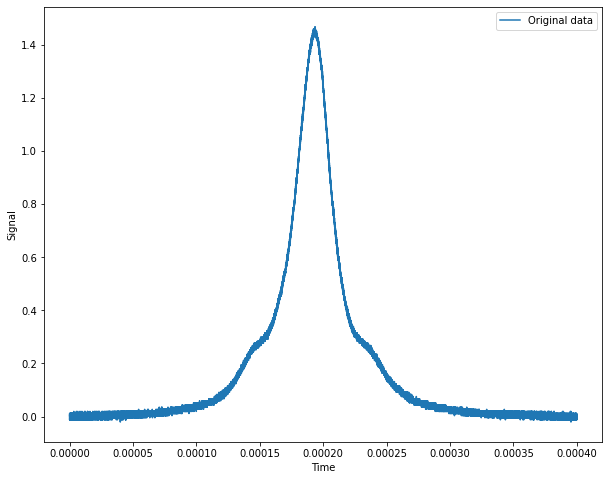

In [4]:
plt.figure(figsize=(10,8))
plt.plot(t,s,label='Original data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

From the derivation of Newton's Method, we arrive the following.

$ m_{n+1} = m_n + (A^{'T} * A^{'})^{-1} * (A^{'T} * r) $

where $r$ is the difference between the data and the model (i.e. residural)

$ r = d - A(m) $

The best fit parameter are as follows 
 Amplitude =  1.4228106806322425 
 Center =  0.0001923586493756531 
 Width =  1.7923690794012603e-05

The Error is calculated to be  0.0006367266230717332


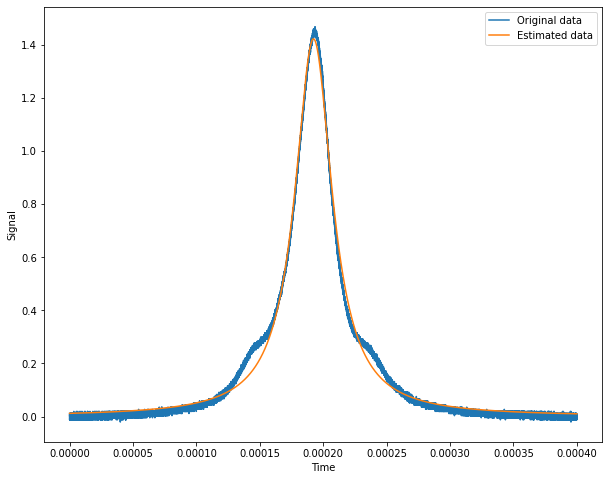

In [5]:
p = np.array([2.0,0.00015,0.0002 ])   # Initial guess of parameters

for i in range(100):
    pred,grad=calc_lorentzian(t,p)
    residual = s - pred
    error = (residual**2).sum() / len(residual)
    residual = np.matrix(residual).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose()*grad
    rhs = grad.transpose()*residual
    dp = np.linalg.inv(lhs)*(rhs)
    for j in range(p.size):
        p[j]=p[j]+dp[j]
    
print('The best fit parameter are as follows \n Amplitude = ', p[0],'\n Center = ', p[1], '\n Width = ', p[2])
print('\nThe Error is calculated to be ', error)

plt.figure(figsize=(10,8))
plt.plot(t,s,label='Original data')
plt.plot(t,pred, label = 'Estimated data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

**(b) Estimating the Noise in the data and using that to calculate the parameters errors**

The error in the parameters is given as,

$ (A^T * N^{-1} * A)^-1$

In [6]:
Noise = np.std(s - pred)**2

pars_errors = ((1/Noise)*np.linalg.inv(lhs))
print('The errors in my parameters is given as  \n', pars_errors)

The errors in my parameters is given as  
 [[ 4.53296500e-01  6.94977525e-11 -5.71723600e-06]
 [ 6.94977525e-11  7.18931394e-11 -2.64071857e-15]
 [-5.71723600e-06 -2.64071857e-15  1.44175607e-10]]


**(c) Fitting using Newton's method - Using Numerical Differentiation**

We use the centered derivative formula to cary out the numerical differentiation

$$ f^{'}  = \frac{f(x + dx) - f(x - dx)}{2*dx} $$

The best fit parameter are as follows 
 Amplitude =  1.4234152245072458 
 Center =  0.00019225158096665602 
 Width =  -1.7908121960468832e-05

The Error is calculated to be  0.0006393863036391846


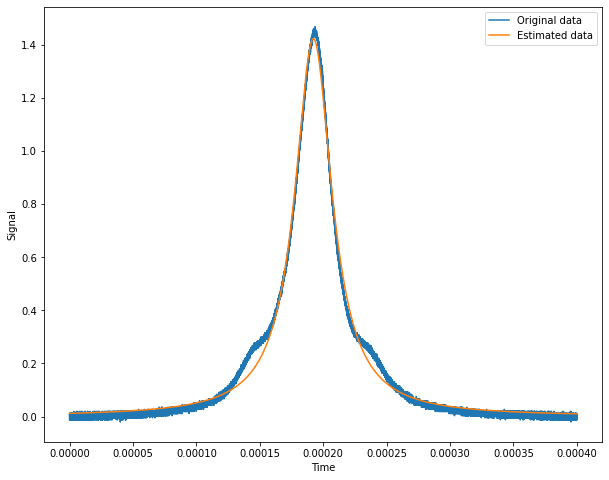

In [7]:
# Let's use a function that accepts a input function and return the derivatives of the function w.r.t to the model parameters
# We initialise the parameters (i.e. pars) and rate of change in parameters (i.e. dpar)

def lorentzian_derivs(fun,pars,dpar,t):
    model = fun(t,pars)
    grad = [None]*len(pars)
    for i in range(len(pars)):
        pp = pars.copy()
        pp[i] = pars[i]+dpar[i]     # f(x + dx)
        m_plus = fun(t,pp)
        pp[i] = pars[i]-dpar[i]     # f(x - dx)
        m_minus = fun(t,pp)
        grad[i]=(m_plus-m_minus)/(2*dpar[i])
    # Ravel the model and gradients into a 1D array
    model = np.ravel(model)
    derivs = np.empty([len(model),len(pars)])
    for i in range(len(pars)):
        derivs[:,i]=np.ravel(grad[i])
    return model,derivs


# Now, let's create a function that does the Newton's method, calculates the best-fit parameters and the error.

def newton(t,pars,dpar,data,fun,niter):
    for i in range(niter):
        model,grad = lorentzian_derivs(fun,pars,dpar,t)
        residual = data - model
        error = (residual**2).sum() / len(residual)
        lhs = grad.T@grad
        rhs = grad.T@residual
        dp = np.linalg.inv(lhs)@rhs
        #print('parameter shifts are ',dp)
        pars=pars+dp
    if len(pars) is 3:
      print('The best fit parameter are as follows \n Amplitude = ', pars[0],'\n Center = ', pars[1], '\n Width = ', pars[2])
    else:
      print('The best fit parameter are as follows \n Value of a = ', pars[0],'\n Center = ', pars[1], '\n Width = ', pars[2], '\n Value of b = ', pars[3],'\n Value of dt = ', pars[4],
            '\n Value of c = ', pars[5])
    print('\nThe Error is calculated to be ', error)
    return pars,grad
    
pars = np.asarray([2.0, 0.00015, 0.0001])   # Initial Guess
dpar = np.asarray([0.1,0.00001,0.00001])
fitp,grad = newton(t,pars,dpar,s,lorentzian,niter=100)
my_model = lorentzian(t,fitp)
plt.figure(figsize=(10,8))
plt.plot(t,s,label='Original data')
plt.plot(t,my_model, label = 'Estimated data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

In [8]:
# Let's see the difference between the Analytical and Numerical Answers

print('The difference in Amplitude is', np.abs(p[0]-fitp[0]),'\n The difference in Center is',np.abs(p[1]-fitp[1]),'\n The difference in width is',np.abs(p[2]-np.abs(fitp[2])))

The difference in Amplitude is 0.000604543875003305 
 The difference in Center is 1.0706840899708564e-07 
 The difference in width is 1.5568833543770828e-08


**(d) Modelling the data as the sum of 3 Lorentzians**

The function we use here is as follows,

$$  d = \frac {a}{1 + (t - t_0)^2 / w^2} + \frac {b}{1 + (t - t_0 + dt)^2 / w^2} + \frac{c}{1 + (t - t_0 - dt)^2 / w^2}  $$

The best fit parameter are as follows 
 Value of a =  1.442738182770984 
 Center =  0.00019247386358705703 
 Width =  1.6071680456762567e-05 
 Value of b =  0.1019997861861481 
 Value of dt =  4.4511768383975473e-05 
 Value of c =  0.06625914056015966

The Error is calculated to be  0.00021479653264607512


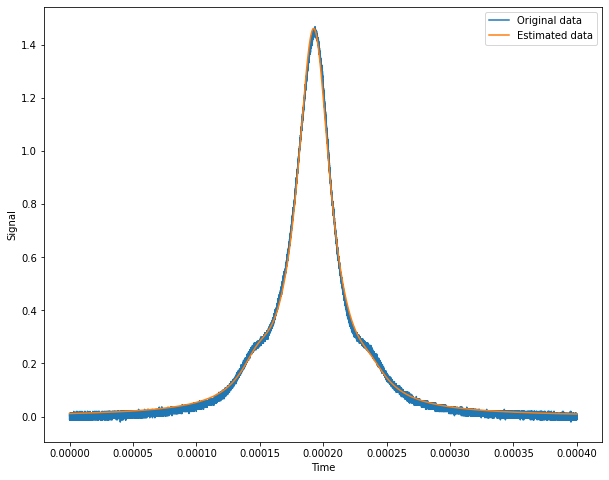

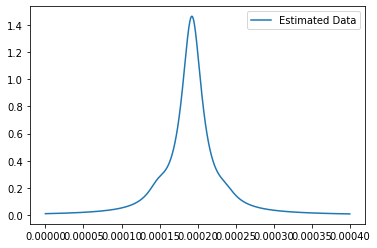

In [104]:
def lorentzian_3(t,pars):
  # Here the parameters are pars = [a,t0,w,b,dt,c] where the width of the 3 lorentzians are same
  return  (pars[0] / (1.0 + ((t-pars[1])**2 / pars[2]**2 ))) + (pars[3] / (1.0 + ((t-pars[1]+pars[4])**2 / pars[2]**2 ))) + (pars[5] / (1.0 + ((t-pars[1]-pars[4])**2 / pars[2]**2 ))) 

# Using the estimates from the earlier fitting, the parameters a, t0 and w are used
# Initial guess is done for b, c and dt as follows

pars = np.asarray([1.4,  0.00019, 0.000017, 0.1, 0.00005,  0.1]) # Initial Guess
dpar = np.asarray([0.1,  0.00001, 0.000001, 0.1, 0.000005, 0.1])
fitp,grad = newton(t,pars,dpar,s,lorentzian_3,niter=100)
my_model = lorentzian_3(t,fitp)
plt.figure(figsize=(10,8))
plt.plot(t,s,label='Original data')
plt.plot(t,my_model, label = 'Estimated data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

plt.plot(t,my_model,label='Estimated Data')
plt.legend()
plt.show()

we see two slight bumps on the either side of the peak. This plot looks reasonable when compared to the previous ones (With a single lorentzian)

In [132]:
# Let's calculate the errors on the parameters

Noise = np.mean(s - my_model)**2

pars_errors = (Noise)*(np.linalg.inv(grad.T@grad))
print('The errors in my parameters is given as  \n', pars_errors)

The errors in my parameters is given as  
 [[ 1.68834009e-08 -2.41579517e-15 -2.03665210e-13  2.00259018e-09
   1.47495991e-13  1.92483133e-09]
 [-2.41579517e-15  3.58762660e-18 -1.03514983e-19  6.52223092e-14
  -2.05266637e-18 -5.74775499e-14]
 [-2.03665210e-13 -1.03514983e-19  7.69706259e-18 -2.09175549e-13
   2.01976908e-17 -1.97198329e-13]
 [ 2.00259018e-09  6.52223092e-14 -2.09175549e-13  1.59017792e-08
  -7.45700589e-13  4.40185305e-09]
 [ 1.47495991e-13 -2.05266637e-18  2.01976908e-17 -7.45700589e-13
   3.90520336e-16 -6.22146481e-13]
 [ 1.92483133e-09 -5.74775499e-14 -1.97198329e-13  4.40185305e-09
  -6.22146481e-13  1.51632347e-08]]


**(e) Analysis of the Residuals**

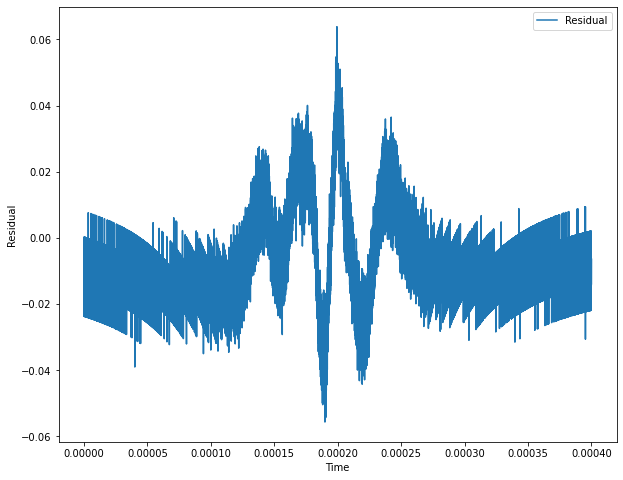

In [133]:
# From the above Fitting, the residuals are

residual = s - my_model
plt.figure(figsize=(10,8))
plt.plot(t,residual,label='Residual')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

Here, I conclude that the error bars I calculated above are not independent with the uniform variance (i.e. the noise). Also, seeing the variations between the data and my best-fit, I dont't think my model is a complete description of data.

**(f) Realisation of Parameter Errors**

In [134]:
# The covariance matrix generated from (d) is

print('The covariance matrix is given as  \n', pars_errors)

parameters = np.random.multivariate_normal(fitp,pars_errors)
print('\n The realisation of parameter errors is \n',parameters)

The covariance matrix is given as  
 [[ 1.68834009e-08 -2.41579517e-15 -2.03665210e-13  2.00259018e-09
   1.47495991e-13  1.92483133e-09]
 [-2.41579517e-15  3.58762660e-18 -1.03514983e-19  6.52223092e-14
  -2.05266637e-18 -5.74775499e-14]
 [-2.03665210e-13 -1.03514983e-19  7.69706259e-18 -2.09175549e-13
   2.01976908e-17 -1.97198329e-13]
 [ 2.00259018e-09  6.52223092e-14 -2.09175549e-13  1.59017792e-08
  -7.45700589e-13  4.40185305e-09]
 [ 1.47495991e-13 -2.05266637e-18  2.01976908e-17 -7.45700589e-13
   3.90520336e-16 -6.22146481e-13]
 [ 1.92483133e-09 -5.74775499e-14 -1.97198329e-13  4.40185305e-09
  -6.22146481e-13  1.51632347e-08]]

 The realisation of parameter errors is 
 [1.44275622e+00 1.92474042e-04 1.60751898e-05 1.01860680e-01
 4.45500853e-05 6.60818749e-02]


My Best-fit chi-square is 130653.26955618242 



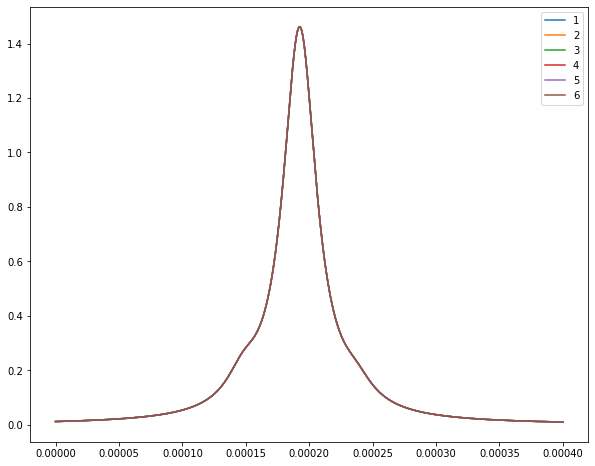


 The chi-square for the models are [130704.55259898008, 130704.55057610261, 130704.55057624253, 130704.55436340829, 130704.55057702643, 130704.55383374002]
 
The difference between Best chi-square and the models are 
 [-51.28304279765871, -51.28101992019219, -51.28102006010886, -51.284807225863915, -51.28102084400598, -51.284277557599125]


In [135]:
# Let's plot these models and see the difference between the chi-squares

# Let's see my best-fit chi-square first...
# my data is 's', my model is 'my_model', my error is 'Noise'

best_chisq = np.sum((s - my_model)**2/np.std(s-my_model)**2)
print('My Best-fit chi-square is',best_chisq,'\n')


from operator import add
plt.figure(figsize=(10,8))
iteration_number = 0

chiq = [None]*len(pars_errors)
for i in pars_errors:
  y = list(map(add, parameters, i))
  model = lorentzian_3(t,y)
  chiq[iteration_number] = np.sum((s - model)**2/np.std(s-model)**2)
  plt.plot(t,model,label=iteration_number+1)
  iteration_number +=1
plt.legend()
plt.show()

print('\n The chi-square for the models are', chiq)

chiq_diff = []
for i in chiq:
  chiq_diff.append(best_chisq - i)

print(' \nThe difference between Best chi-square and the models are \n',chiq_diff)

**(g) MCMC Fitting**

In [147]:
# Let's define a function to generate the trial steps
# 'fitp' is our best-fit parameters.................................which is our a here
# 'pars_errors' is our parameter covariance estimate from (d)...... which is our b here

def get_step(a,cov):
    return np.random.multivariate_normal(a,cov)

# Defining a function to calculate the model using the parameters and finding the chi-square of the model

def calc_chisq(t,pars,data,noise):
    model = lorentzian_3(t,pars)
    chisq = np.sum((model - data)**2)
    return model,chisq

def mcmc_chain(fun,t,pars,cov,data,noise,nstep):
    npar = len(pars)
    chain = np.zeros([nstep,npar])  # To store the values of parameter shifts
    chisq = np.zeros(nstep)         # To store the values of chi-square
    chain[0,:] = pars
    model,chi_cur = fun(t,pars,data,noise)
    chisq[0] = chi_cur
    record = []
    for i in range(1,nstep):
        pp = pars + get_step(pars,cov)
        model,new_chisq = fun(t,pp,data,noise)
        record.append(new_chisq)
        accept_prob = np.exp(-0.5*(new_chisq-chi_cur))
        if np.random.rand(1)<accept_prob:    # If the probability is greater than 1, accept the new parameters, as our chi-square improved!
            pars = pp                        # Assign the new parameters
            chi_cur = new_chisq    
        chain[i,:]=pars    # Update the paramter shifts
        chisq[i]=chi_cur   # Update the chi-square list
    residual = data - model
    error = (residual**2).sum() / len(residual)
    return chain,chisq,record,error

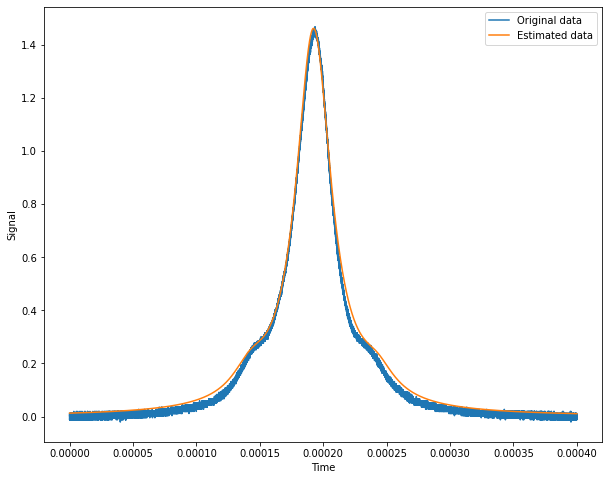


My Error  is 0.9895863202617398


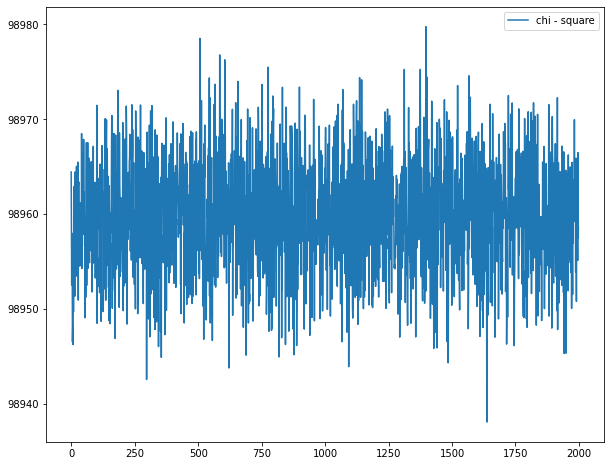

In [156]:
pars = np.asarray([1.4427,  0.0001924, 0.000017, 0.1, 0.00005,  0.091])
chain, chisq,record,error = mcmc_chain(calc_chisq, t, pars, pars_errors, s, Noise, 2000)

# Let's take a look at the final fit we got...

plt.figure(figsize=(10,8))
plt.plot(t,s,label='Original data')
plt.plot(t,lorentzian_3(t,chain[-1]), label = 'Estimated data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()

print('\nMy Error  is', error)
# Let's see the chi-square variations
plt.figure(figsize=(10,8))
plt.plot(record,label='chi - square')
plt.legend()
plt.show()

**(h) Actual width of the cavity resonance**

In [171]:
freq_data = np.fft.fft(s)

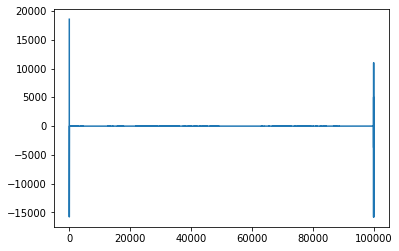

In [174]:
plt.plot(np.real(freq_data))
plt.show()